Stock Closing Price Prediction <br> Sentiment Analysis and Classification with ERNIE Pre-Trained Model<br>
By: Lie Reubensto

# Stock Closing Price Prediction

In [1]:
# Install Requirements (You don't have to run this if you already have these modules installed)
# !pip install keras-self-attention
# !pip install transformers

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten
from keras_self_attention import SeqSelfAttention
from transformers import AutoTokenizer, AutoModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

c:\Users\Ruben\anaconda3\lib\site-packages\transformers\utils\generic.py:482: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\Ruben\anaconda3\lib\site-packages\transformers\utils\generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Load Data
path = "./X.csv"
data = pd.read_csv(path)

In [3]:
# See first five rows of data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,304.904572,76180670.0
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,322.666016,105493978.0
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,331.546692,59712955.0
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,334.506927,56236668.0
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,340.427429,31319315.0


In [4]:
# Since we're focusing solely on closing price, we're gonna use only two relevat columns
data = data[['Date', 'Close']]

In [5]:
# See new data
data.head()

,Date,Close
0,2005-09-29,432.588074
1,2005-09-30,457.787384
2,2005-10-03,470.387024
3,2005-10-04,474.586914
4,2005-10-05,482.986694


In [6]:
# See Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3808 non-null   object 
 1   Close   3807 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.6+ KB


In [7]:
# Check missing value on data
data.isnull().sum()

Date     0
Close    1
dtype: int64

In [8]:
# Drop row with missing value
data.dropna(inplace=True)

In [9]:
# Check missing value on data again (should be no more missing value)
data.isnull().sum()

Date     0
Close    0
dtype: int64

In [10]:
# See descripive statistics of 'close' column
data.describe()

,Close
count,3807.000000
mean,1207.159945
std,665.202070
min,287.000000
25%,765.000000
50%,957.573608
75%,1595.956055
max,4241.883301


In [11]:
# See how many unique elements per column
data.nunique()

Date     3807
Close     648
dtype: int64

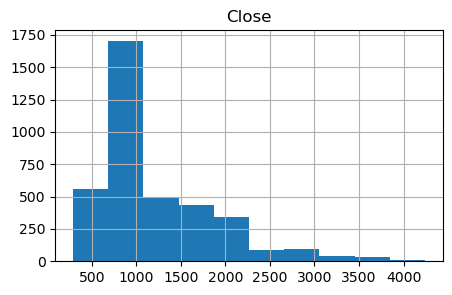

In [12]:
# Plot histogram of 'close' column
data.hist(figsize=(5, 3))
plt.show()

In [13]:
# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

# Sort the dataset by date
data.sort_values(by='Date', inplace=True)

C:\Users\Ruben\AppData\Local\Temp\ipykernel_55192\2861358268.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)


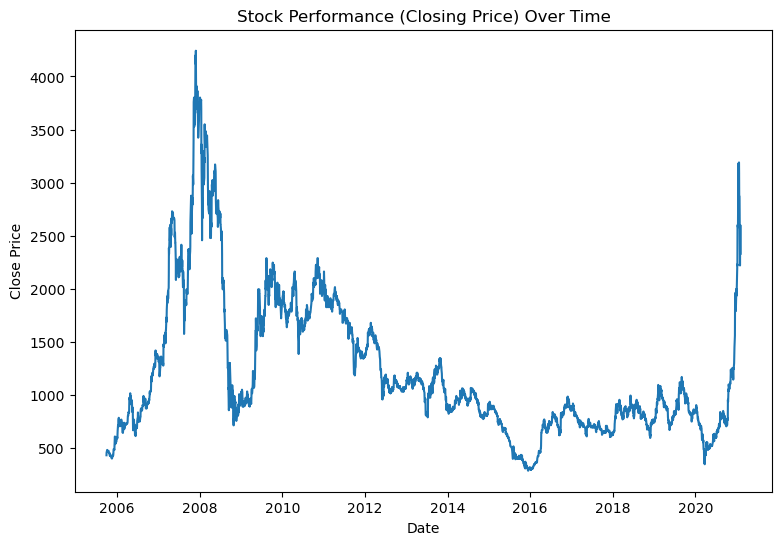

In [14]:
# Plot Closing Price over time
plt.figure(figsize=(9, 6))
plt.plot(data['Date'], data['Close'])
plt.title('Stock Performance (Closing Price) Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [15]:
# Scale the 'close' data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
data

,Date,Close
0,2005-09-29,0.036812
1,2005-09-30,0.043184
2,2005-10-03,0.046370
3,2005-10-04,0.047432
4,2005-10-05,0.049556
...,...,...
3803,2021-01-28,0.529219
3804,2021-01-29,0.488763
3805,2021-02-01,0.584847
3806,2021-02-02,0.539333


In [16]:
# Create input and output segments
window_size = 5
horizon = 1
inputs = []
outputs = []

for i in range(len(data) - window_size - horizon + 1):
    input = data['Close'].iloc[i:i+window_size].values
    output = data['Close'].iloc[i+window_size:i+window_size+horizon].values
    inputs.append(input)
    outputs.append(output)

In [17]:
# Convert inputs and outputs to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

In [18]:
# Splitting Data
x_train, x_val, y_train, y_val = train_test_split(inputs, outputs, test_size=0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, shuffle=False)
print(len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test))

3041 3041 380 380 381 381


In [19]:
# Reshape inputs (size, window_size, features)
x_train = x_train.reshape((x_train.shape[0], window_size, 1))
x_val = x_val.reshape((x_val.shape[0], window_size, 1))
x_test = x_test.reshape((x_test.shape[0], window_size, 1))

In [20]:
# Create Model
model1 = Sequential()
model1.add(Bidirectional(LSTM(100, input_shape=(window_size, 1), return_sequences=True)))
model1.add(SeqSelfAttention(attention_activation='sigmoid'))
model1.add(Flatten())
model1.add(Dense(units=horizon))

In [21]:
# Compile Model
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [22]:
# Train Model
model1.fit(x_train, y_train, epochs=10, batch_size=24, validation_data=(x_val, y_val), verbose=2)

Epoch 1/10


c:\Users\Ruben\anaconda3\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


127/127 - 6s - loss: 0.0038 - mae: 0.0285 - val_loss: 7.8644e-05 - val_mae: 0.0072 - 6s/epoch - 44ms/step
Epoch 2/10
127/127 - 1s - loss: 3.3049e-04 - mae: 0.0108 - val_loss: 8.0997e-05 - val_mae: 0.0073 - 631ms/epoch - 5ms/step
Epoch 3/10
127/127 - 1s - loss: 3.3847e-04 - mae: 0.0113 - val_loss: 8.5586e-05 - val_mae: 0.0072 - 628ms/epoch - 5ms/step
Epoch 4/10
127/127 - 1s - loss: 3.0535e-04 - mae: 0.0105 - val_loss: 8.1598e-05 - val_mae: 0.0070 - 635ms/epoch - 5ms/step
Epoch 5/10
127/127 - 1s - loss: 3.1124e-04 - mae: 0.0107 - val_loss: 5.5260e-05 - val_mae: 0.0057 - 631ms/epoch - 5ms/step
Epoch 6/10
127/127 - 1s - loss: 3.0332e-04 - mae: 0.0109 - val_loss: 1.0003e-04 - val_mae: 0.0080 - 636ms/epoch - 5ms/step
Epoch 7/10
127/127 - 1s - loss: 2.8364e-04 - mae: 0.0103 - val_loss: 6.1503e-05 - val_mae: 0.0060 - 628ms/epoch - 5ms/step
Epoch 8/10
127/127 - 1s - loss: 2.8908e-04 - mae: 0.0107 - val_loss: 5.2952e-05 - val_mae: 0.0055 - 618ms/epoch - 5ms/step
Epoch 9/10
127/127 - 1s - loss: 2

In [23]:
# Model Evaluation
model1.evaluate(x_test, y_test, batch_size=24)

16/16 [==============================] - 0s 2ms/step - loss: 4.5773e-04 - mae: 0.0114


[0.00045772764133289456, 0.011402768082916737]

In [24]:
# Inverse transform the predictions and actual values to original scale
predictions = model1.predict(x_test)
predictions = scaler.inverse_transform(np.reshape(predictions, (predictions.shape[0], horizon)))
y_test_original = scaler.inverse_transform(y_test)

12/12 [==============================] - 1s 3ms/step


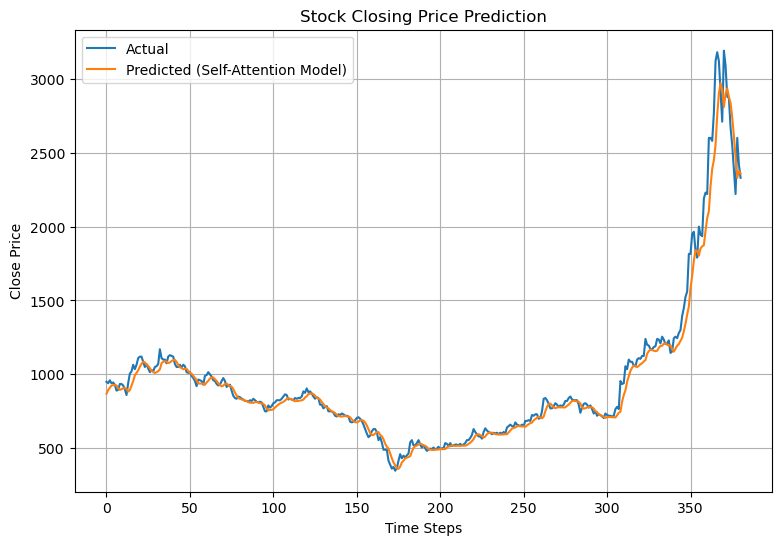

In [30]:
# Visualization
plt.figure(figsize=(9, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted (Self-Attention Model)')
plt.title('Stock Closing Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Sentiment Analysis and Classification with ERNIE Pre-Trained Model

In [31]:
# Load Data
path = "./Emotion.csv"
data = pd.read_csv(path)

In [32]:
# See first five rows of data
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [33]:
# See data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [34]:
# See the total of unique elements in each column (you should see six labels, indicating six types of emotions)
print(f'Count of unique elements in Dataset:\n{data.nunique()}\n')

Count of unique elements in Dataset:
text     19948
label        6
dtype: int64



In [35]:
# Check missing value from data
data.isnull().sum()

text     0
label    0
dtype: int64

In [36]:
# See duplicated rows of data
print(f"Duplicated Rows in Dataset: {data.duplicated().sum()}")

Duplicated Rows in Dataset: 1


There's exist one duplicated row, but it's not going to be treated here (since it's not going to impact the model significantly later)

In [37]:
# Apply a bit of text cleansing
data['text'].apply(lambda x: str.lower(str(x)))
data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', str(x)))

# Show how many rows each type of emotion has
for label in data['label'].unique():
  print(f"{label} Sentiments:\n{data[data['label']==label].count()}\n")

sadness Sentiments:
text     5797
label    5797
dtype: int64

anger Sentiments:
text     2709
label    2709
dtype: int64

love Sentiments:
text     1641
label    1641
dtype: int64

surprise Sentiments:
text     719
label    719
dtype: int64

fear Sentiments:
text     2373
label    2373
dtype: int64

joy Sentiments:
text     6761
label    6761
dtype: int64



In [41]:
# Load pre-trained ERNIE model and tokenizer
num_classes = len(data['label'].unique())
model_name = "nghuyong/ernie-2.0-base-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model2 = AutoModel.from_pretrained(model_name)

In [42]:
# Convert non-numerical labels to numerical values
le = LabelEncoder()
numerical_labels = le.fit_transform(data['label'])

In [43]:
# Tokenize input texts
inputs = tokenizer(data['text'].tolist(), return_tensors="pt", padding=True)

In [44]:
# Prepare data for model training and testing
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Split data into train, val, and test
x_train_ids, x_temp_ids, x_train_mask, x_temp_mask, y_train, y_temp = train_test_split(input_ids, attention_mask, numerical_labels, test_size=0.3, random_state=33)
x_val_ids, x_test_ids, x_val_mask, x_test_mask, y_val, y_test = train_test_split(x_temp_ids, x_temp_mask, y_temp, test_size=0.5, random_state=33)

x_train_ids = torch.tensor(x_train_ids)
x_train_mask = torch.tensor(x_train_mask)
y_train = torch.tensor(y_train)

x_val_ids = torch.tensor(x_val_ids)
x_val_mask = torch.tensor(x_val_mask)
y_val = torch.tensor(y_val)

x_test_ids = torch.tensor(x_test_ids)
x_test_mask = torch.tensor(x_test_mask)
y_test = torch.tensor(y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(x_train_ids, x_train_mask, y_train)
val_dataset = TensorDataset(x_val_ids, x_val_mask, y_val)
test_dataset = TensorDataset(x_test_ids, x_test_mask, y_test)

# Create PyTorch DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\Ruben\AppData\Local\Temp\ipykernel_33824\3499239082.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_ids = torch.tensor(x_train_ids)
C:\Users\Ruben\AppData\Local\Temp\ipykernel_33824\3499239082.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_mask = torch.tensor(x_train_mask)
C:\Users\Ruben\AppData\Local\Temp\ipykernel_33824\3499239082.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_ids = torch.tensor(x_val_ids)
C:\Users\Ruben\AppData\Local\Temp\ipykernel_33824\3499239082.py:13: UserWarning: To co

In [45]:
# Create hidden layer for the model
hidden_size = model2.config.hidden_size
num_classes = len(data['label'].unique())

classification_head = nn.Sequential(
    nn.Linear(hidden_size, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# Create the custom ERNIE Classifier class
class CustomERNIEClassifier(nn.Module):
    def __init__(self, ernie_model, classification_head):
        super(CustomERNIEClassifier, self).__init__()
        self.ernie_model = ernie_model
        self.classification_head = classification_head

    def forward(self, input_ids, attention_mask):
        outputs = self.ernie_model(input_ids, attention_mask=attention_mask)
        pooled_output = outputs['last_hidden_state'][:, 0, :]  # use token [CLS]
        logits = self.classification_head(pooled_output)
        return logits

# Create an instance of the custom classifier
custom_classifier = CustomERNIEClassifier(model2, classification_head)
custom_classifier.to(device)

CustomERNIEClassifier(
  (ernie_model): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(4, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0-11): 12 x ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [47]:
# Freezing the ERNIE Pre-Trained Model's layers
for param in custom_classifier.ernie_model.parameters():
    param.requires_grad = False

In [48]:
# Preparing fr Compiling the Model
optimizer = optim.AdamW(custom_classifier.classification_head.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [50]:
# Training Model
epochs = 10

for epoch in range(epochs):
    custom_classifier.train()
    for input_ids, masks, labels in train_dataloader:
        input_ids, masks, labels = input_ids.to(device), masks.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = custom_classifier(input_ids, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [51]:
# Evaluate Model (summary)
custom_classifier.eval()

CustomERNIEClassifier(
  (ernie_model): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(4, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0-11): 12 x ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [52]:
# Predict model's result
pred = []
true = []

with torch.no_grad():
    for input_ids, masks, labels in test_dataloader:
        input_ids, masks, labels = input_ids.to(device), masks.to(device), labels.to(device)
        outputs = custom_classifier(input_ids, masks)
        predictions = torch.argmax(outputs, dim=1)
        pred.extend(predictions.cpu().numpy())
        true.extend(labels.cpu().numpy())

In [53]:
# Evaluate model's metrics
accuracy = accuracy_score(true, pred)
precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='weighted')

print("--- Model Performance ---")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

--- Model Performance ---
Accuracy: 0.504
Precision: 0.369
Recall: 0.504
F1 Score: 0.416


c:\Users\Ruben\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
